In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

barnstable_data = pd.read_excel("barnstable_analysis_data.xlsx", sheet_name = "data")
barnstable_data['date'] = pd.to_datetime(barnstable_data['date'])
barnstable_data.set_index('date', inplace = True)

barnstable_data.head()

,SPX,TB1M
date,,
1926-01-30,-0.001783,0.003061
1926-02-27,-0.033297,0.002612
1926-03-31,-0.057708,0.002601
1926-04-30,0.038522,0.002270
1926-05-28,0.013623,0.002691


### 1 Summary Statistics

In [46]:
subperiods = {
    "1965 - 1999" : (1965, 1999),
    "2000 - END": (2000, barnstable_data.index.year.max() ),
    "1926 - END" : (1926, barnstable_data.index.year.max())
}

ANNUAL_FACTOR = 12

barnstable_data['excess_r_m'] = barnstable_data['SPX'] - barnstable_data['TB1M']

#Log Levels:
barnstable_data['log_SPX'] = np.log(1 + barnstable_data['SPX'])
barnstable_data['log_TB1M'] = np.log(1 + barnstable_data['TB1M'])
barnstable_data['excess_log_m'] = barnstable_data['log_SPX'] - barnstable_data['log_TB1M']

def annual_stats(data):
    mean = data.mean() * ANNUAL_FACTOR
    vol = data.std() * np.sqrt(ANNUAL_FACTOR)
    return mean, vol

#Show Results in DataFrame:
outputs = []
for period, (start, end) in subperiods.items():
    subperiod = barnstable_data[(barnstable_data.index.year >= start) & \
                                (barnstable_data.index.year <= end)]
    #Levels:
    rm_mean, rm_vol = annual_stats(subperiod['SPX'])
    rxm_mean, rxm_vol = annual_stats(subperiod['excess_r_m'])
    rf_mean, rf_vol = annual_stats(subperiod['TB1M'])

    #Log Levels:
    rm_log_mean, rm_log_vol = annual_stats(subperiod['log_SPX'])
    rxm_log_mean, rxm_log_vol = annual_stats(subperiod['excess_log_m'])
    rf_log_mean, rf_log_vol = annual_stats(subperiod['log_TB1M'])

    outputs.append({
        "Period" : period,
        "r_m_mean" : rm_mean, "r_m_vol": rm_vol,
        "r_tilde_m_mean" : rxm_mean, "r_tilde_m_vol" : rxm_vol,
        "r_f_mean" : rf_mean, "r_f_vol": rf_vol,
        "log_r_m_mean" : rm_log_mean, "log_r_m_vol" : rm_log_vol,
        "log_r_tilde_m_mean": rxm_log_mean, "log_r_tilde_m_vol": rxm_log_vol,
        "log_r_f_mean" : rf_log_mean, "log_r_f_vol" :rf_log_vol
    })

summary_stats = pd.DataFrame(outputs).set_index("Period").round(5)
summary_stats.T

Period,1965 - 1999,2000 - END,1926 - END
r_m_mean,0.12935,0.08754,0.11553
r_m_vol,0.14941,0.15281,0.18665
r_tilde_m_mean,0.06866,0.07009,0.08331
r_tilde_m_vol,0.15023,0.15309,0.18733
r_f_mean,0.06150,0.01745,0.03193
r_f_vol,0.00718,0.00555,0.00851
log_r_m_mean,0.11760,0.07555,0.09782
log_r_m_vol,0.14957,0.15376,0.18594
log_r_tilde_m_mean,0.05706,0.05813,0.06561
log_r_tilde_m_vol,0.15040,0.15403,0.18655


### Full Sample vs Sub-Sample:

Looking at the values above, all three categories had a similar performance. Breaking this down, it looks like the performance of the period from 2000-END is lower than that of 1965-1999, and the 1926-END period captures somewhere in between the other categories' performances. 

Of note, the 1965-1999 period has the highest mean market return (~12%). Also, the mean risk-free rate sharply falls after 2000 to 1.7%, down from a  mean of 6% in the period before. 

### Level Stats vs Log Stats:

Although the log stats have a slightly lower mean than the level stats, the volatility stats for both categories are nearly identical. This indicates that log(1+r) = r holds well and log approximations work well for this specific data.


### 2 Probability of Underperformance

In [ ]:
#2.1 - probability for 1965-1999
mu = summary_stats.loc['1965 - 1999', 'log_r_tilde_m_mean']
sigma = summary_stats.loc['1965 - 1999', 'log_r_tilde_m_vol']
sharpe = mu / sigma
sharpe = sharpe.round(5)

print('Probability of Underperformance from 1965 - 1999: ', sharpe)


Probability of Underperformance from 1965 - 1999:  0.37939


In [48]:
#2.2 - precise probability for h = 15 & h = 30 years
def p_underperform(h):
    return norm.cdf(-np.sqrt(h) * sharpe)

precise_stats = pd.DataFrame({
    "15 Years" : [p_underperform(15)],
    "30 Years" : [p_underperform(30)]
}).T
precise_stats.columns = ['Probability of Underperformance']
precise_stats

,Probability of Underperformance
15 Years,0.070866
30 Years,0.018854


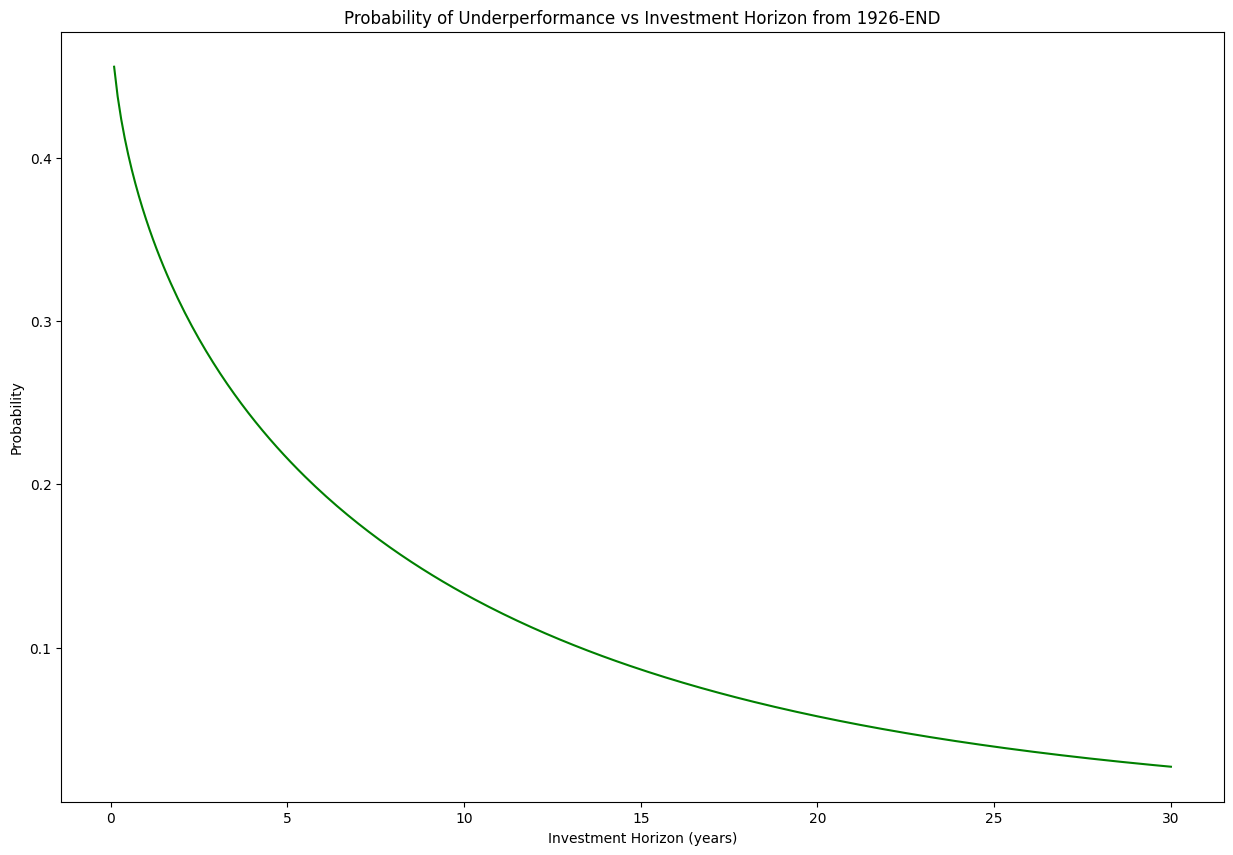

In [50]:
#2.3 - plot probability
mu_full = summary_stats.loc['1926 - END', 'log_r_tilde_m_mean']
sigma_full = summary_stats.loc['1926 - END', 'log_r_tilde_m_vol']
sharpe_full = mu_full / sigma_full
h = np.linspace(0.1, 30, 300)
p_h = norm.cdf(-np.sqrt(h) * sharpe_full)

plt.figure(figsize = (15,10))
plt.plot(h, p_h, color = 'green')
plt.xlabel('Investment Horizon (years)')
plt.ylabel('Probability')
plt.title('Probability of Underperformance vs Investment Horizon from 1926-END')
plt.show()

### 3 Full Sample Analysis

### 4 IS Estimate & OOS Likelihood